In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demo for 2 DoF models

The aim of this demo code is to compare the resolts form sloving the equation of motion with the data from the simulations. This code uses only 1 dataset, therefore the results can't be used for the learning part.

In [55]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy
import equation_solver_2DoF as solv
import lmfit
print( os.path.abspath('') )
project_code_path =  os.path.dirname( os.path.abspath('') )
print( project_code_path )
function_path = os.path.join( project_code_path, 'function_files')
print( function_path )
sys.path.append(function_path)
import krc_reader
import filterSAEJ211
import data_saver as data

sp.init_printing()
from sympy import symbols

c:\Users\emmaf\Documents\7. félév\SZAKDOLGOZAT\osd_dummy_modeling_2\osd_dummy_modeling\model1_2dof_inverse_pendulum
c:\Users\emmaf\Documents\7. félév\SZAKDOLGOZAT\osd_dummy_modeling_2\osd_dummy_modeling
c:\Users\emmaf\Documents\7. félév\SZAKDOLGOZAT\osd_dummy_modeling_2\osd_dummy_modeling\function_files


In [56]:
base_path = os.path.join( os.path.dirname( os.path.abspath('') ), 'Dataset')
path_EU = os.path.join( base_path, 'EU2' )
path_US = os.path.join( base_path, 'US' )

# sim_repl_lib_paths = [ path_US  ]
sim_repl_lib_paths = [ path_EU, path_US  ]

krc_data_reader = krc_reader.KeyResultCurveDataReader( sim_repl_lib_paths )
krc_data_reader.load_replications_results( moving_average_win_len=10 )
simulation_time_vals = krc_data_reader.get_time_values()
krc_data_reader.remove_channels_from_all_replications( [ '11CHST0000H3DSX0' ] )
krc_data_reader.remove_replications( [ ('US', 'SO000'), ('US', 'SO019'), ('US', 'SO095'), ('EU2', 'SO095') ] ) #('US', 'SO024'), ('US', 'SO056'),
print( krc_data_reader.get_channels_with_missing_data() )


[]


In [57]:
simulation_time_vales = krc_data_reader.get_time_values()
channels_in_data = krc_data_reader.get_available_channels()
simulation_ids = krc_data_reader.get_available_replications()
print( simulation_time_vals )
print( channels_in_data )
print( simulation_ids )

[0.0000000e+00 9.9540000e-05 1.9970999e-04 ... 1.3970123e-01 1.3980141e-01
 1.3990158e-01]
{'11CHST0000H3ACX0', '11HEAD0000H3ACX0', '11SEBE0000B3FOR0', '11NECKUP00H3FOY0', '11FEMRRI00H3FOX0', '11FEMRLE00H3FOX0', '11LUSP0000H3FOZ0', '11SEBE0000B6FOR0', '11FEMRLE00H3FOY0', '11HEAD0000H3ACY0', '11SEBE0000B5FOR0', '11PELV0000H3ACY0', '11NECKUP00H3FOZ0', '11NECKUP00H3MOY0', '10SLEDFRMI00ACX0', '11PELV0000H3ACX0', '11LUSP0000H3MOX0', '11PELV0000H3ACZ0', '11CHST0000H3ACZ0', '11LUSP0000H3MOZ0', '11NECKUP00H3MOX0', '11FEMRLE00H3FOZ0', '11LUSP0000H3MOY0', '11FEMRRI00H3FOY0', '11NECKUP00H3FOX0', '11SEBE0000B4FOR0', '11LUSP0000H3FOX0', '11LUSP0000H3FOY0', '11CHST0000H3ACY0', '11HEAD0000H3ACZ0', '11FEMRRI00H3FOZ0', '11NECKUP00H3MOZ0'}
[('EU2', 'SO000'), ('EU2', 'SO001'), ('US', 'SO001'), ('EU2', 'SO002'), ('US', 'SO002'), ('EU2', 'SO003'), ('US', 'SO003'), ('EU2', 'SO004'), ('US', 'SO004'), ('EU2', 'SO005'), ('US', 'SO005'), ('EU2', 'SO006'), ('US', 'SO006'), ('EU2', 'SO007'), ('US', 'SO007'), ('EU

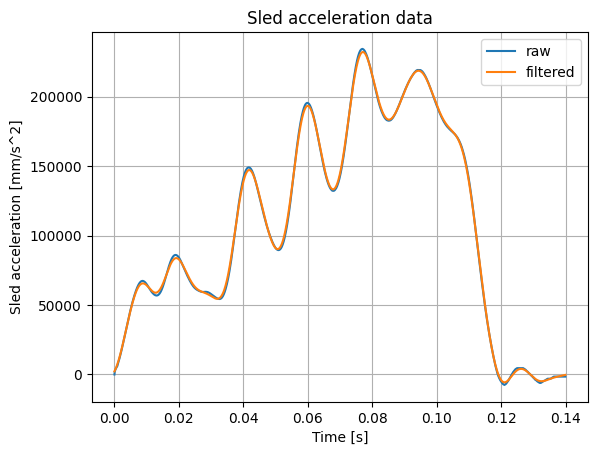

In [58]:
single_simulation_data = krc_data_reader.get_single_replication_results( ('EU2', 'SO006') )
sled_acc_raw = single_simulation_data['10SLEDFRMI00ACX0']
sled_acc = filterSAEJ211.filterSAEJ211( sled_acc_raw, 6, 0.001 )

plt.figure()
plt.plot( simulation_time_vals, sled_acc_raw, label='raw' )
plt.plot( simulation_time_vals, sled_acc, label='filtered' )
plt.xlabel('Time [s]')
plt.ylabel('Sled acceleration [mm/s^2]')
plt.title("Sled acceleration data")
plt.legend()
plt.grid()
plt.show()

[ True  True  True ...  True  True  True]


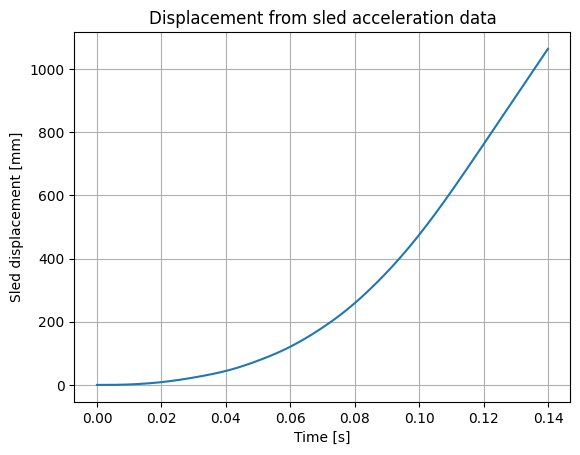

In [59]:
acceleration_data = np.array( sled_acc ) # mm/s^2
acceleration_interpolated = scipy.interpolate.interp1d( simulation_time_vals, acceleration_data )

def f( t, y ):
    dx_dt = y[1]
    dv_dt = acceleration_interpolated(t)
    return [ dx_dt, dv_dt ]

sled_sol = scipy.integrate.solve_ivp( f, ( simulation_time_vals[0], simulation_time_vals[-1] ), np.array([0, 0]), 'RK45', simulation_time_vals )
sled_time = sled_sol.t
sled_velo = sled_sol.y[1]
sled_disp = sled_sol.y[0]

print( sled_time == simulation_time_vals )


# Plotting the results
plt.figure()
plt.plot( simulation_time_vals, sled_disp )
plt.xlabel('Time [s]')
plt.ylabel('Sled displacement [mm]')
plt.title("Displacement from sled acceleration data")
plt.grid()
plt.show()

In [60]:
# gives back displacement and velocity values that can be substituted back to the equation 
def num_solver(ddx_num, ddphi_num, gain_input, time_input, y0, k, k_t):

    gain_interpolated = scipy.interpolate.interp1d(time_input, gain_input)
    k = [float(k) for t in time_input]
    k = np.array(k)
    k_interpolated = scipy.interpolate.interp1d(time_input, k)
    k_t = [float(k_t) for t in time_input]
    k_t = np.array(k_t)
    k_t_interpolated = scipy.interpolate.interp1d(time_input, k_t)

    # Defineing the system of ODEs
    def system(t, y):
        x_val, dx_val, phi_val, dphi_val = y

        r = gain_interpolated(t)
        k = k_interpolated(t)
        k_t = k_t_interpolated(t)
        
        ddx_val = float( ddx_num(t, x_val, dx_val, phi_val, dphi_val, r, k, k_t) )
        ddphi_val = float( ddphi_num(t, x_val, dx_val, phi_val, dphi_val, r, k, k_t) )

        return [dx_val, ddx_val, dphi_val, ddphi_val]
    
    solution = scipy.integrate.solve_ivp( system, ( time_input[0], time_input[-1] ), y0, 'RK45', time_input )

    t_val = solution.t
    x_val = solution.y[0]
    dx_val = solution.y[1]
    phi_val = solution.y[2]
    dphi_val = solution.y[3]
    
    return x_val, dx_val, phi_val, dphi_val, t_val

In [61]:
def acceleration_substituted(ddx_num, ddphi_num, gain_input, time_input, y0, k, k_t):
    x_values, dx_values, phi_values, dphi_values, _ = num_solver(ddx_num, ddphi_num, gain_input, time_input, y0, k, k_t)

    ddx_subst = ddx_num(time_input, x_values, dx_values, phi_values, dphi_values, gain_input, k, k_t)
    ddphi_subst = ddphi_num(time_input, x_values, dx_values, phi_values, dphi_values, gain_input, k, k_t)

    return ddx_subst, ddphi_subst

Gain is in mm t_vales is in microsec.

Solution of differential equation: {Derivative(phi(t), (t, 2)): 6.0*k*l*x(t)*cos(phi(t))/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m) - 6.0*k*r(t)*cos(phi(t))/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) + 12.0*k_t*phi(t)/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m) + 3.0*l**2*m*sin(phi(t))*cos(phi(t))*Derivative(phi(t), t)**2/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m), Derivative(x(t), (t, 2)): 4.0*k*l*x(t)/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) - 4.0*k*r(t)/(3.0*m*cos(phi(t))**2 - 4.0*m) + 6.0*k_t*phi(t)*cos(phi(t))/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) + 2.0*l**2*m*sin(phi(t))*Derivative(phi(t), t)**2/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m)}
ddx_num_expr: 4120.0*k*x(t)/(240093.0*cos(phi(t))**2 - 320124.0) - 4.0*k*r(t)/(233.1*cos(phi(t))**2 - 310.8) + 6.0*k_t*phi(t)*cos(phi(t))/(240093.0*cos(phi(t))**2 - 320124.0) + 164863860.0*sin(phi(t))*Derivative(phi(t), t)**2/(240093.0*cos(phi(t))**2 - 320124.0)


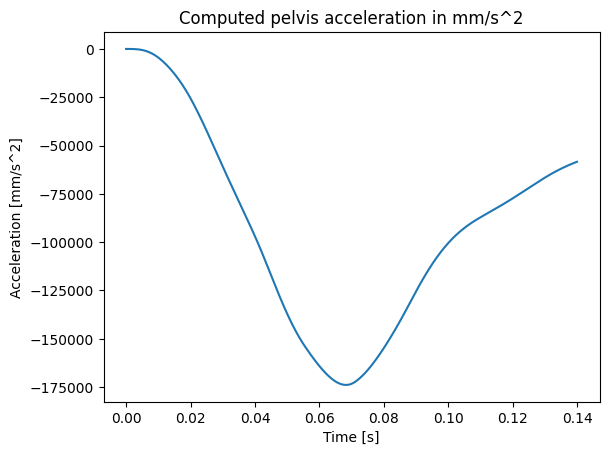

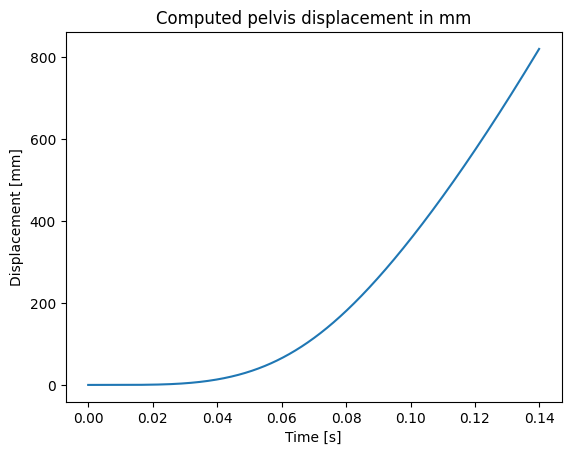

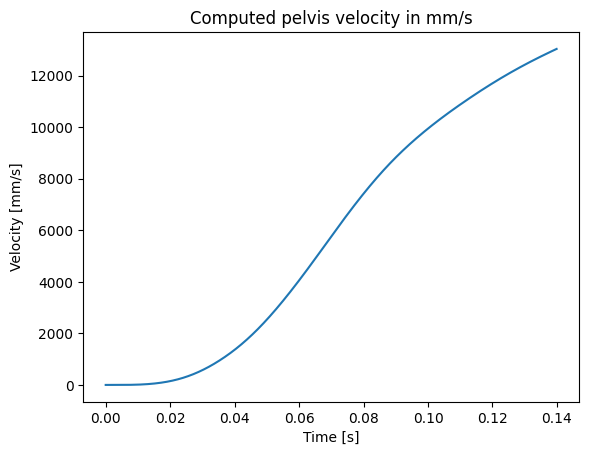

In [62]:
# Define constants
m, l =symbols("m l")
data = [(m, 77.7), (l, 1.03)]

# Solving second order Lagrange
ddx_num, ddphi_num = solv.symbolic_solver(77.7, 1.03*10**3)

y0 = np.array( [0,0,0,0] )
k_values = 6.1e4 # needs to be optimized later
k_t_values = 9.2e4 # needs to be optimized later
x_computed, dx_computed, phi_computed, dphi_computed, t_computed = \
    num_solver(ddx_num, ddphi_num, sled_disp, simulation_time_vals, y0, k_values, k_t_values)

acceleration_computed, angular_acceleration_computed = \
    acceleration_substituted(ddx_num, ddphi_num, sled_disp, t_computed, y0, k_values, k_t_values)
acceleration_computed = -acceleration_computed


plt.figure()
plt.plot( simulation_time_vals, acceleration_computed )
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mm/s^2]')
plt.title("Computed pelvis acceleration in mm/s^2")
# plt.grid() # kikapcsolható
plt.show()

plt.figure()
plt.plot( simulation_time_vals, x_computed )
plt.xlabel('Time [s]')
plt.ylabel('Displacement [mm]')
plt.title("Computed pelvis displacement in mm")
# plt.grid() # kikapcsolható
plt.show()

plt.figure()
plt.plot( simulation_time_vals, dx_computed )
plt.xlabel('Time [s]')
plt.ylabel('Velocity [mm/s]')
plt.title("Computed pelvis velocity in mm/s")
# plt.grid() # kikapcsolható
plt.show()

Text(0.5, 1.0, 'Pelvis acceleration from dataset [mm/s]')

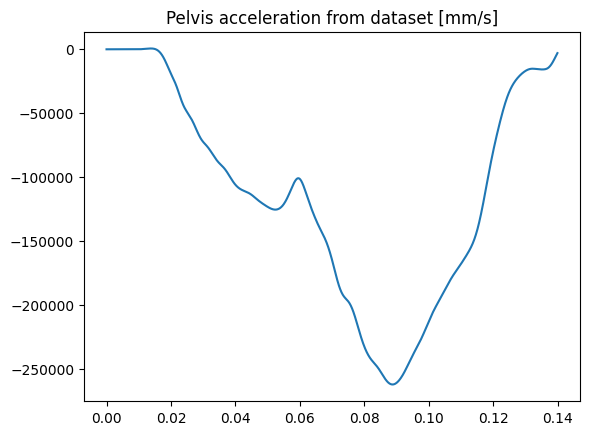

In [63]:
pelv_acc_raw = single_simulation_data['11PELV0000H3ACX0']
pelv_acc = filterSAEJ211.filterSAEJ211( pelv_acc_raw, 6, 0.001 )
plt.plot( simulation_time_vals, pelv_acc )
plt.title( "Pelvis acceleration from dataset [mm/s]" )

[-0.00000000e+00 -3.73700276e-02 -1.60169841e-01 ... -5.85287519e+04
 -5.84660516e+04 -5.84038076e+04]


Text(0.5, 1.0, 'Comparison of simulated and computed results')

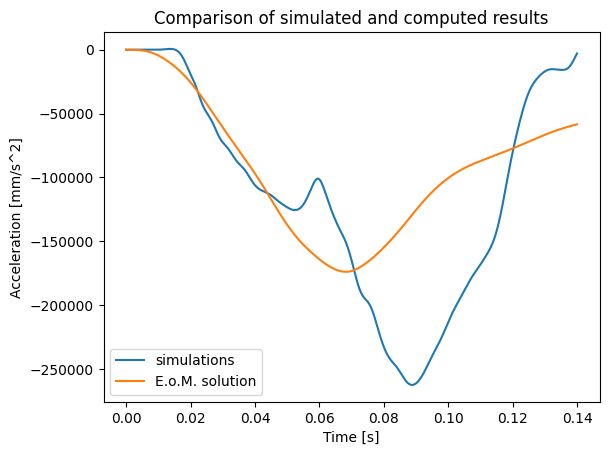

In [64]:
plt.figure()
plt.plot( simulation_time_vals, pelv_acc, label ='simulations')
plt.plot( simulation_time_vals, acceleration_computed, label = 'E.o.M. solution')
print( acceleration_computed )
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [mm/s^2]')
plt.title("Comparison of simulated and computed results")

# Lmfit trial

In [65]:
# Define constants
m, l =symbols("m l")
dummy_body_data = { m: 77.7, l: 1.03*10**3 } # [kg, mm]

# Solving second order Lagrange
# ddx_num, ddphi_num = solv.symbolic_solver(77.7, 1.03*10**3)
ddx_num, ddphi_num = solv.symbolic_solver( dummy_body_data[m], dummy_body_data[l] )

def pelv_obj_func( params ):

    k_values = params['k']
    k_t_values = params['k_t']

    y0 = np.array( [0,0,0,0] )

    acceleration_computed, angular_acceleration_computed = \
        acceleration_substituted( ddx_num, ddphi_num, sled_disp, simulation_time_vals, y0, k_values, k_t_values )
    acceleration_computed = -acceleration_computed

    return ( pelv_acc - acceleration_computed )**2

Solution of differential equation: {Derivative(phi(t), (t, 2)): 6.0*k*l*x(t)*cos(phi(t))/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m) - 6.0*k*r(t)*cos(phi(t))/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) + 12.0*k_t*phi(t)/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m) + 3.0*l**2*m*sin(phi(t))*cos(phi(t))*Derivative(phi(t), t)**2/(3.0*l**2*m*cos(phi(t))**2 - 4.0*l**2*m), Derivative(x(t), (t, 2)): 4.0*k*l*x(t)/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) - 4.0*k*r(t)/(3.0*m*cos(phi(t))**2 - 4.0*m) + 6.0*k_t*phi(t)*cos(phi(t))/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m) + 2.0*l**2*m*sin(phi(t))*Derivative(phi(t), t)**2/(3.0*l*m*cos(phi(t))**2 - 4.0*l*m)}
ddx_num_expr: 4120.0*k*x(t)/(240093.0*cos(phi(t))**2 - 320124.0) - 4.0*k*r(t)/(233.1*cos(phi(t))**2 - 310.8) + 6.0*k_t*phi(t)*cos(phi(t))/(240093.0*cos(phi(t))**2 - 320124.0) + 164863860.0*sin(phi(t))*Derivative(phi(t), t)**2/(240093.0*cos(phi(t))**2 - 320124.0)


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
k    1.63e+05        0      inf     1081     True     None     None
k_t  1.645e+04        0      inf 1.194e+08     True     None     None


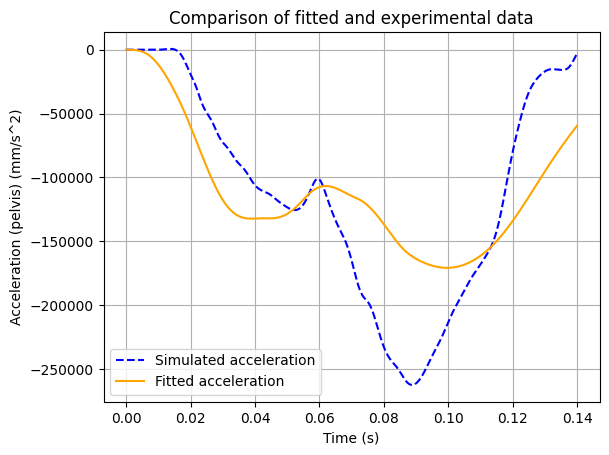

In [66]:
params = lmfit.Parameters()
# set up the initial parameter values
params.add('k', min=0, max = None, value=1e5, vary = True)    # N/mm
params.add('k_t', min=0, max = None, value=3e5, vary = True) # Nmm/rad

results = lmfit.minimize( pelv_obj_func, params, "least_squares" )

k_opt = results.params['k']
k_t_opt = results.params['k_t']

results.params.pretty_print()

pelvis_acceleration_fitted, _ = \
    acceleration_substituted( ddx_num, ddphi_num, sled_disp, simulation_time_vals, y0, k_opt, k_t_opt )
pelvis_acceleration_fitted = -pelvis_acceleration_fitted

plt.figure()
plt.plot( simulation_time_vals, pelv_acc, label='Simulated acceleration', linestyle='--', color='blue')
plt.plot( simulation_time_vals, pelvis_acceleration_fitted, label ='Fitted acceleration', linestyle='-',color='orange')
plt.title('Comparison of fitted and experimental data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (pelvis) (mm/s^2)')
plt.legend()
plt.grid(True)

In [67]:
sum( results.residual )

In [69]:
def pelv_obj_func( params ):

    k_values = params['k']
    k_t_values = params['k_t']

    y0 = np.array( [0,0,0,0] )

    acceleration_computed, angular_acceleration_computed = \
        acceleration_substituted( ddx_num, ddphi_num, sled_disp, simulation_time_vals, y0, k_values, k_t_values )
    acceleration_computed = -acceleration_computed

    return ( pelv_acc - acceleration_computed )**2 # + (chest)**2 + (head)**2

def grid_search_obj( params_init_vals ):

    k_init = params_init_vals["k_init"]
    k_t_init = params_init_vals["k_t_init"]

    params = lmfit.Parameters()

    params.add('k', min=0, max = None, value=k_init, vary = True)    # N/mm
    params.add('k_t', min=0, max = None, value=k_t_init, vary = True) # Nmm/rad 

    results = lmfit.minimize( pelv_obj_func, params, "least_squares" )

    return sum( results.residual )

params_init_vals = lmfit.Parameters()
params_init_vals.add('k_init', min=0, max = 1e6, value=0, vary = True, brute_step=1e5 )    # N/mme
params_init_vals.add('k_t_init', min=0, max = 1e6, value=0, vary = True, brute_step=1e5 ) # Nmm/rad

results_brute = lmfit.minimize( grid_search_obj, params_init_vals, "brute" )

k_init_opt = results_brute.params['k_init']
k_t_init_opt = results_brute.params['k_t_init']

In [ ]:
results_brute.params.pretty_print()

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
k_init       1e+05        0    1e+06     None     True     None    1e+05
k_t_init     4e+05        0    1e+06     None     True     None    1e+05


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
k    2.322e+05        0      inf     1808     True     None     None
k_t  1.062e+04        0      inf 8.654e+07     True     None     None


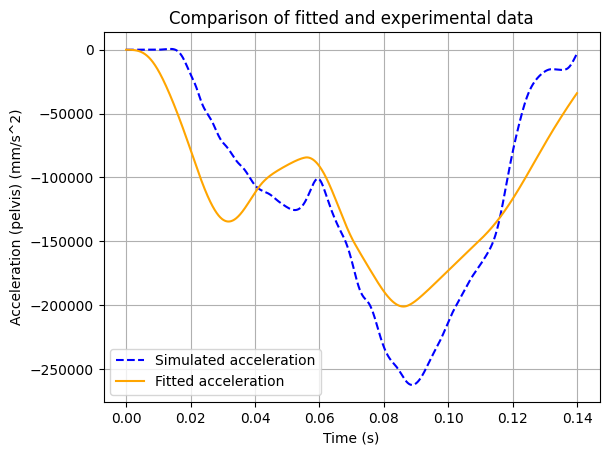

In [ ]:
params_with_opt_init = lmfit.Parameters()

params_with_opt_init.add( 'k', min=0, max = None, value=k_init_opt, vary = True )    # N/mm
params_with_opt_init.add( 'k_t', min=0, max = None, value=k_t_init_opt, vary = True ) # Nmm/rad 

results_with_opt_init = lmfit.minimize( pelv_obj_func, params_with_opt_init, "least_squares" )

k_opt = results_with_opt_init.params['k']
k_t_opt = results_with_opt_init.params['k_t']

results_with_opt_init.params.pretty_print()

pelvis_acceleration_fitted, _ = \
    acceleration_substituted( ddx_num, ddphi_num, sled_disp, simulation_time_vals, y0, k_opt, k_t_opt )
pelvis_acceleration_fitted = -pelvis_acceleration_fitted

plt.figure()
plt.plot( simulation_time_vals, pelv_acc, label='Simulated acceleration', linestyle='--', color='blue')
plt.plot( simulation_time_vals, pelvis_acceleration_fitted, label ='Fitted acceleration', linestyle='-',color='orange')
plt.title('Comparison of fitted and experimental data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (pelvis) (mm/s^2)')
plt.legend()
plt.grid(True)